### Imports

In [1]:
import os
import re
import cv2
import numpy as np
import torch
import faiss
from PIL import Image
from transformers import AutoProcessor, AutoModel
import av
import math
from utils import *
import pandas as pd

VIDEO_DIR = "input_videos"
EMB_FILE  = "embeddings.npy"
ID_FILE   = "embedding_ids.npy"
INDEX_PATH = "clip_index.faiss"

/home/jupyter-dai7591/.conda/envs/dedup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load GPU

In [2]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
if device == "cuda:1":
    print(f"running on GPU: {device}")
else:
    print("running on CPU")

running on GPU: cuda:1


### Infer, index, store 

In [3]:
# Model config 
CKPT      = "microsoft/xclip-base-patch32"
processor = AutoProcessor.from_pretrained(CKPT)
model     = AutoModel.from_pretrained(CKPT).to(device)
dim = 512
BATCH = 256

# Create memmaps
max_rows = scan_dir(VIDEO_DIR)
print(f"number of total segments in directory: {max_rows}")
emb_memmap = create_memap(file_path=EMB_FILE, 
                          dtype=np.float32,
                          shape=(max_rows, dim),
                          init_value=0.0)

id_memmap = create_memap(file_path=ID_FILE,
                        dtype=np.int64,
                        shape=(max_rows,),
                        init_value=-1)

# Create index 
index = faiss.IndexFlatL2(dim)
index = faiss.IndexIDMap2(index)

# Run infernece and index 
total_clips, final_write_ptr = process_video_directory(
    VIDEO_DIR, processor, model, index, emb_memmap, id_memmap, BATCH
)

print(f"Successfully processed {total_clips} video clips")
print(f"Data written to positions 0-{final_write_ptr-1} in memory arrays")
assert final_write_ptr == total_clips, "Mismatch between clips and write position!"

faiss.write_index(index, INDEX_PATH)
print("FAISS index saved to disk.")

number of total segments in directory: 1737
[Batch 1] Inference on 256 IDs: 10 … 1626 → writing at rows 0 … 255
[Batch 1] added to FAISS (index size now: 256)
[Batch 2] Inference on 256 IDs: 1627 … 227 → writing at rows 256 … 511
[Batch 2] added to FAISS (index size now: 512)
[Batch 3] Inference on 256 IDs: 228 … 2796 → writing at rows 512 … 767
[Batch 3] added to FAISS (index size now: 768)
[Batch 4] Inference on 256 IDs: 2797 … 314 → writing at rows 768 … 1023
[Batch 4] added to FAISS (index size now: 1024)
[Batch 5] Inference on 256 IDs: 315 … 394 → writing at rows 1024 … 1279
[Batch 5] added to FAISS (index size now: 1280)
[Batch 6] Inference on 256 IDs: 395 … 643 → writing at rows 1280 … 1535
[Batch 6] added to FAISS (index size now: 1536)
[Batch 7] Inference on 200 IDs: 644 … 897 → writing at rows 1536 … 1735
[Batch 7] added to FAISS (index size now: 1736)
Total segments written: 1736
FAISS index size: 1736
Successfully processed 1736 video clips
Data written to positions 0-1735 

### Find duplicates

In [6]:
index = faiss.read_index(INDEX_PATH)

# Get the distance matrix and check distribution 
distance_matrix, id_rows, faiss_ids, all_clip_ids = prepare_search_matrices(index, EMB_FILE)

print("Distance statistics:")
print(f"Min distance: {distance_matrix.min():.4f}")
print(f"Max distance: {distance_matrix.max():.4f}")
print(f"Mean distance: {distance_matrix.mean():.4f}")
print(f"Median distance: {np.median(distance_matrix):.4f}")
print(f"95th percentile: {np.percentile(distance_matrix, 95):.4f}")

# Check distances excluding self-similarity (column 0)
non_self_distances = distance_matrix[:, 1:].flatten()
non_self_distances = non_self_distances[non_self_distances > 0]  # Remove zeros
print(f"\nNon-self distances:")
print(f"Min: {non_self_distances.min():.4f}")
print(f"Max: {non_self_distances.max():.4f}")
print(f"Mean: {non_self_distances.mean():.4f}")

# Remove duplicates and ensure unique thresholds
thresholds = [
    0.0,      # Exact matches (159 pairs)
    0.0001,   # Very strict (52 pairs) 
    0.0002,   # Moderate (97 pairs)
    0.0003,   # Slightly more inclusive (104 pairs)
    0.0004,   # All near-duplicates (107 pairs)
    0.001     # Safety margin (same as 0.0004)
]

# Remove any duplicates while preserving order
unique_thresholds = []
seen = set()
for thresh in thresholds:
    if thresh not in seen:
        unique_thresholds.append(thresh)
        seen.add(thresh)

thresholds = unique_thresholds
print(f"\nUnique thresholds in the critical range (0.0-0.05):")
print(f"Thresholds: {thresholds}")
print(f"Number of unique thresholds: {len(thresholds)}")

# Run analysis with unique thresholds only
df_results = analyze_multiple_thresholds(distance_matrix, id_rows, faiss_ids, thresholds)

# Create DataFrame and export
df_results = df_results.sort_values(['File_name'], ignore_index=True)
output_file = "threshold_deduplication_results.csv"
df_results.to_csv(output_file, index=False)
print(f"Results exported to {output_file}")

# Print summary
print(f"\nSummary:")
print(f"Total files analyzed: {len(df_results)}")
print(f"Thresholds tested: {len(thresholds)}")

# Simple threshold effectiveness analysis
print(f"\nThreshold effectiveness analysis:")
for thresh in thresholds:
    is_dup_col = f'Is_duplicate_{thresh:.3f}'
    total_non_dup_col = f'Total_non_duplicates_{thresh:.3f}'
    
    # Try .2f formatting if .3f doesn't exist
    if is_dup_col not in df_results.columns:
        is_dup_col = f'Is_duplicate_{thresh:.2f}'
        total_non_dup_col = f'Total_non_duplicates_{thresh:.2f}'
    
    if is_dup_col in df_results.columns and total_non_dup_col in df_results.columns:
        # Count files that are duplicates
        dup_count = df_results[is_dup_col].sum()  # Sum of True values
        total_files = len(df_results)
        non_dup_count = total_files - dup_count
        percentage = (dup_count / total_files) * 100
        
        print(f"Threshold {thresh:7.3f}: {dup_count:3d} duplicates ({percentage:5.1f}%), {non_dup_count:4d} unique files")
    else:
        print(f"Warning: Columns for threshold {thresh} not found in results")
        
print(f"\nFirst 10 rows:")
print(df_results.head(10).to_string())

Loading embeddings and performing FAISS search...
Prepared matrices for 1737 embeddings with k=100 neighbors
Distance statistics:
Min distance: 0.0000
Max distance: 587.9579
Mean distance: 178.1177
Median distance: 167.3908
95th percentile: 338.4974

Non-self distances:
Min: 0.0000
Max: 587.9579
Mean: 180.2496

Unique thresholds in the critical range (0.0-0.05):
Thresholds: [0.0, 0.0001, 0.0002, 0.0003, 0.0004, 0.001]
Number of unique thresholds: 6
Processing threshold: 0.0000
Processing threshold: 0.0001
Processing threshold: 0.0002
Processing threshold: 0.0003
Processing threshold: 0.0004
Processing threshold: 0.0010
Results exported to threshold_deduplication_results.csv

Summary:
Total files analyzed: 1418
Thresholds tested: 6

Threshold effectiveness analysis:

First 10 rows:
       File_name  Video_length  Threshold_0.0000 Duplicate_names_0.0000  Is_duplicate_0.0000  Total_non_duplicates_0.0000  Threshold_0.0001 Duplicate_names_0.0001  Is_duplicate_0.0001  Total_non_duplicates_0.

In [7]:
# Detailed debugging to find exact threshold borders
print("Detailed threshold border analysis:")
prev_dup_count = None
prev_thresh = None

for thresh in thresholds[:20]:  # Check first 20 thresholds in detail
    duplicates_ids = find_duplicates_at_threshold(distance_matrix, id_rows, faiss_ids, thresh)
    dup_count = len(duplicates_ids)
    
    # Show when the count changes
    if prev_dup_count is not None and dup_count != prev_dup_count:
        print(f"*** CHANGE: Threshold {prev_thresh:.4f} -> {thresh:.4f}: {prev_dup_count} -> {dup_count} duplicate pairs")
    
    print(f"Threshold {thresh:7.4f}: {dup_count:3d} duplicate pairs")
    
    # Show distance distribution for this threshold
    mask = (distance_matrix <= thresh) & (distance_matrix > 0.0)  # Exclude self-matches
    matching_distances = distance_matrix[mask]
    if len(matching_distances) > 0:
        unique_distances = np.unique(matching_distances)
        print(f"  - Unique distances <= {thresh}: {len(unique_distances)} values")
        print(f"  - Distance range: {unique_distances.min():.6f} to {unique_distances.max():.6f}")
        if len(unique_distances) <= 10:
            print(f"  - All distances: {[f'{d:.6f}' for d in unique_distances]}")
        else:
            print(f"  - Sample distances: {[f'{d:.6f}' for d in unique_distances[:5]]} ... {[f'{d:.6f}' for d in unique_distances[-5:]]}")
    
    prev_dup_count = dup_count
    prev_thresh = thresh
    print()

Detailed threshold border analysis:
Threshold  0.0000: 159 duplicate pairs

*** CHANGE: Threshold 0.0000 -> 0.0001: 159 -> 52 duplicate pairs
Threshold  0.0001:  52 duplicate pairs
  - Unique distances <= 0.0001: 4 values
  - Distance range: 0.000015 to 0.000092
  - All distances: ['0.000015', '0.000031', '0.000061', '0.000092']

*** CHANGE: Threshold 0.0001 -> 0.0002: 52 -> 97 duplicate pairs
Threshold  0.0002:  97 duplicate pairs
  - Unique distances <= 0.0002: 7 values
  - Distance range: 0.000015 to 0.000183
  - All distances: ['0.000015', '0.000031', '0.000061', '0.000092', '0.000122', '0.000153', '0.000183']

*** CHANGE: Threshold 0.0002 -> 0.0003: 97 -> 104 duplicate pairs
Threshold  0.0003: 104 duplicate pairs
  - Unique distances <= 0.0003: 9 values
  - Distance range: 0.000015 to 0.000244
  - All distances: ['0.000015', '0.000031', '0.000061', '0.000092', '0.000122', '0.000153', '0.000183', '0.000214', '0.000244']

*** CHANGE: Threshold 0.0003 -> 0.0004: 104 -> 107 duplicate 

Distance distribution in range 0-0.1:
Total distances: 214
Min: 0.000031
Max: 0.000366
Mean: 0.000112


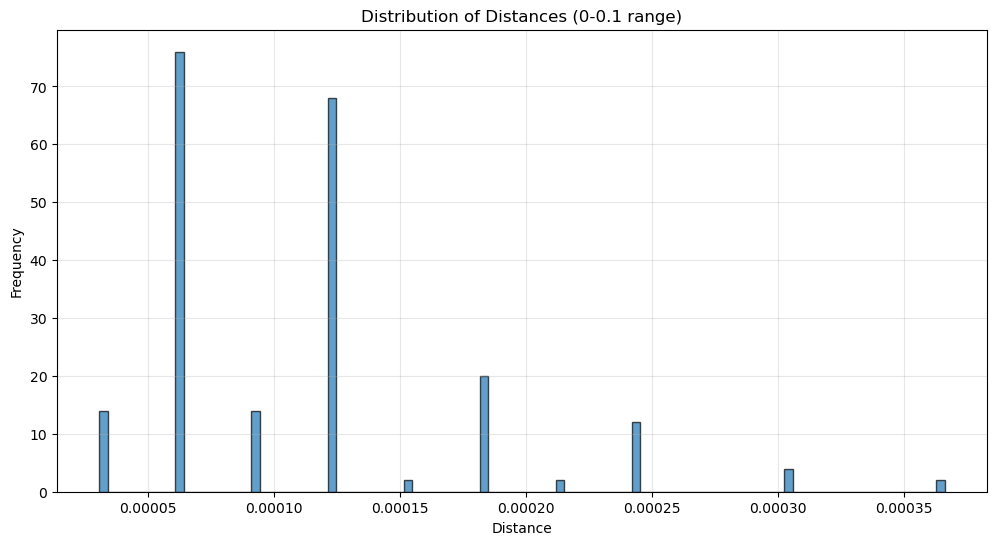


Distance quantiles:
10th percentile: 0.000061
25th percentile: 0.000061
50th percentile: 0.000122
75th percentile: 0.000122
90th percentile: 0.000183
95th percentile: 0.000244
99th percentile: 0.000305


In [8]:
# Create a histogram of distances in the critical range
import matplotlib.pyplot as plt

# Get non-self distances in the critical range
non_self_distances = distance_matrix[:, 1:].flatten()
non_self_distances = non_self_distances[non_self_distances > 0]  # Remove zeros
critical_distances = non_self_distances[non_self_distances <= 0.1]  # Focus on 0-0.1 range

print(f"Distance distribution in range 0-0.1:")
print(f"Total distances: {len(critical_distances)}")
print(f"Min: {critical_distances.min():.6f}")
print(f"Max: {critical_distances.max():.6f}")
print(f"Mean: {critical_distances.mean():.6f}")

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(critical_distances, bins=100, alpha=0.7, edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Distances (0-0.1 range)')
plt.grid(True, alpha=0.3)
plt.show()

# Show quantiles to understand distribution
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
print(f"\nDistance quantiles:")
for q in quantiles:
    val = np.quantile(critical_distances, q)
    print(f"{q*100:2.0f}th percentile: {val:.6f}")